# LSTM Model for Crypto Price Prediction

**Target**: Predicting whether the crypto price will be higher in 5 days than it is today  
**Method**: Long Short-Term Memory (LSTM) neural network with TensorFlow/Keras

## LSTM
- LSTM has 3 gates (Input, Forget, Output) vs GRU's 2 gates (Update, Reset)
- LSTM has separate cell state and hidden state (better long-term memory)
- LSTM typically has ~30% more parameters than GRU

In [ ]:
# Standard libraries
import pandas as pd
import numpy as np
import random
import datetime
from pathlib import Path 

# TensorFlow
import tensorflow as tf

# Random seeds for reproducibility
SEED = 42  # Changed from 101 to match script
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Visualization
import matplotlib.pyplot as plt

# Modeling
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error

# MLflow for experiment tracking
import mlflow

mlflow.set_tracking_uri("http://127.0.0.1:5001")
mlflow.set_experiment("lstm_experiment")

In [ ]:
# Load data
DATA_PATH = Path("/Users/ina/Documents/spicedAcademy/time_series_project/data/final_data/20251115_dataset_crp.csv")

# Error handling for file operations
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Data file not found: {DATA_PATH}")

df_lstm = pd.read_csv(DATA_PATH)

In [ ]:
# Train-Validation-Test Split (70%-15%-15% temporal split)
split_date_train = "2024-07-01"  # Training until this date
split_date_val = "2024-10-01"    # Validation from here
split_date_test = "2024-10-01"   # Fixed: removed 3-month gap

df_train = df_lstm[df_lstm['date'] < split_date_train].copy()
df_val = df_lstm[(df_lstm['date'] >= split_date_train) & (df_lstm['date'] < split_date_val)].copy()
df_test = df_lstm[df_lstm['date'] >= split_date_test].copy()

print(f"\nTraining set: {len(df_train)} samples")
print(f"Validation set: {len(df_val)} samples")
print(f"Test set: {len(df_test)} samples")
print(f"Train up to date: {df_train['date'].max()}")
print(f"Validation from date: {df_val['date'].min()} to {df_val['date'].max()}")
print(f"Test from date: {df_test['date'].min()}")

In [4]:
# Prepare features and targets - KEEP 'ticker' and 'date' for sequence creation
# For LSTM, we need these columns to:
# - Sort data chronologically (date)
# - Create sequences per cryptocurrency (ticker)

# Features: exclude targets but KEEP 'ticker' and 'date' temporarily
feature_cols = [col for col in df_train.columns 
                if col not in ['future_5_close_higher_than_today', 'future_10_close_higher_than_today',
                              'future_5_close_lower_than_today', 'future_10_close_lower_than_today',
                              'higher_close_today_vs_future_5_close', 'higher_close_today_vs_future_10_close',
                              'lower_close_today_vs_future_5_close', 'lower_close_today_vs_future_10_close']]

X_train = df_train[feature_cols].copy()
y_train = df_train["future_5_close_higher_than_today"].values

X_val = df_val[feature_cols].copy()
y_val = df_val["future_5_close_higher_than_today"].values

X_test = df_test[feature_cols].copy()
y_test = df_test["future_5_close_higher_than_today"].values

# Scaling - GLOBAL scaling (all tickers together)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Prepare data for scaling (exclude ticker and date from scaling)
cols_to_scale = [col for col in X_train.columns if col not in ['ticker', 'date']]

# Fit on training data ONLY (avoid leakage)
X_train_scaled_vals = scaler_X.fit_transform(X_train[cols_to_scale])
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

# Transform validation and test data
X_val_scaled_vals = scaler_X.transform(X_val[cols_to_scale])
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).ravel()

X_test_scaled_vals = scaler_X.transform(X_test[cols_to_scale])
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

print(f"Features shape: {X_train_scaled_vals.shape}")
print(f"Target shape: {y_train_scaled.shape}")
print(f"Note: 'ticker' and 'date' kept for sequence creation")

Features shape: (142034, 68)
Target shape: (142034,)
Note: 'ticker' and 'date' kept for sequence creation


In [5]:
# Create sequences for LSTM (convert 2D to 3D data)
# LSTM needs: (samples, timesteps, features) instead of (samples, features)

def create_sequences(X_data, y_data, df, look_back=10):
    """Create sliding window sequences for each crypto separately
    
    Returns sequences AND original indices for alignment
    """
    
    X_sequences = []
    y_sequences = []
    original_indices = []  # Track which original row each sequence comes from
    
    # Process each cryptocurrency separately
    for ticker in df['ticker'].unique():
        # Get data for this crypto only
        mask = df['ticker'] == ticker
        ticker_indices = df[mask].index.values  # Original dataframe indices
        crypto_X = X_data[mask]
        crypto_y = y_data[mask]
        crypto_dates = df.loc[mask, 'date'].values
        
        # Sort by date (important for time series!)
        order = np.argsort(crypto_dates)
        crypto_X = crypto_X[order]
        crypto_y = crypto_y[order]
        ticker_indices = ticker_indices[order]
        
        # Create sliding windows
        for i in range(len(crypto_X) - look_back):
            X_sequences.append(crypto_X[i:i+look_back])  # Past days
            y_sequences.append(crypto_y[i + look_back])  # Future target
            original_indices.append(ticker_indices[i + look_back])  # Track original index
    
    return np.array(X_sequences), np.array(y_sequences), np.array(original_indices)


# Settings
look_back = 20  # Use past 20 days to predict

# Create sequences for all splits
print("Creating sequences...")
X_train_seq, y_train_seq, train_indices = create_sequences(X_train_scaled_vals, y_train_scaled, X_train, look_back)
X_val_seq, y_val_seq, val_indices = create_sequences(X_val_scaled_vals, y_val_scaled, X_val, look_back)
X_test_seq, y_test_seq, test_indices = create_sequences(X_test_scaled_vals, y_test_scaled, X_test, look_back)

# Get dimensions for model
n_features = X_train_seq.shape[2]

print(f"\nShape: {X_train_seq.shape}")
print(f"   {X_train_seq.shape[0]} sequences")
print(f"   {look_back} days look-back")
print(f"   {n_features} features")
print(f"   Indices tracked for alignment")

Creating sequences...

Shape: (139766, 20, 68)
   139766 sequences
   20 days look-back
   68 features
   Indices tracked for alignment


In [6]:
# MODEL ARCHITECTURE - LSTM for Time Series Prediction

# Hyperparameters
lstm_units = 64
lstm_dropout = 0.3
use_second_lstm = True
dense_units = 32
dense_dropout = 0.2
learning_rate = 0.0001
L2_regularization = 0.0001

# Build model based on configuration
if use_second_lstm:
    model_lstm = Sequential([
        Input(shape=(look_back, n_features)),
        
        # First LSTM layer
        LSTM(lstm_units, 
             return_sequences=True,  # MUST be True for stacked LSTM
             kernel_regularizer=tf.keras.regularizers.l2(L2_regularization),
             name='lstm_layer_1'),
        Dropout(lstm_dropout, name='dropout_1'),
        
        # Second LSTM layer
        LSTM(lstm_units // 2, 
             return_sequences=False,  # False for last LSTM layer
             kernel_regularizer=tf.keras.regularizers.l2(L2_regularization),
             name='lstm_layer_2'),
        Dropout(lstm_dropout, name='dropout_2'),
        
        # Output layer
        Dense(1, activation='linear', name='output')
    ])
else:
    model_lstm = Sequential([
        Input(shape=(look_back, n_features)),
        
        # Single LSTM layer
        LSTM(lstm_units, 
             return_sequences=False,  # Only output last timestep
             kernel_regularizer=tf.keras.regularizers.l2(L2_regularization),
             name='lstm_layer'),
        Dropout(lstm_dropout, name='dropout'),
        
        # Output layer
        Dense(1, activation='linear', name='output')
    ])

# Compile model
model_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mae',
    metrics=['mae', 'mse']
)

print("LSTM Model Architecture:")
model_lstm.summary()

LSTM Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_layer_1 (LSTM)             │ (None, 20, 64)         │        34,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer_2 (LSTM)             │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,497 (181.63 KB)

 Trainable params: 46,497 (181.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# TRAIN LSTM MODEL

# Training parameters
epochs = 100
batch_size = 128  # Smaller batch size for LSTM (memory intensive)
patience = 10

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=patience,
    restore_best_weights=True,
    verbose=1
)

# Train model with sequences
print("Training LSTM model...")
history = model_lstm.fit(
    X_train_seq, y_train_seq,  # 3D sequences
    validation_data=(X_val_seq, y_val_seq),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping],
    verbose=1
)

Training LSTM model...
Epoch 1/100


In [ ]:
# Training metrics from the last epoch
mae_train = history.history['mae'][-1]
mse_train = history.history['mse'][-1]
print("Train Set Performance:")
print(f"   MAE:  {mae_train:.4f}")
print(f"   MSE:  {mse_train:.4f}")

val_mae = history.history['val_mae'][-1]
val_mse = history.history['val_mse'][-1]
print("\nValidation Set Performance:")
print(f"   MAE:  {val_mae:.4f}")
print(f"   MSE:  {val_mse:.4f}")

Train Set Performance:
   MAE:  0.5601
   MSE:  0.6492

Validation Set Performance:
   MAE:  0.6706
   MSE:  0.7925


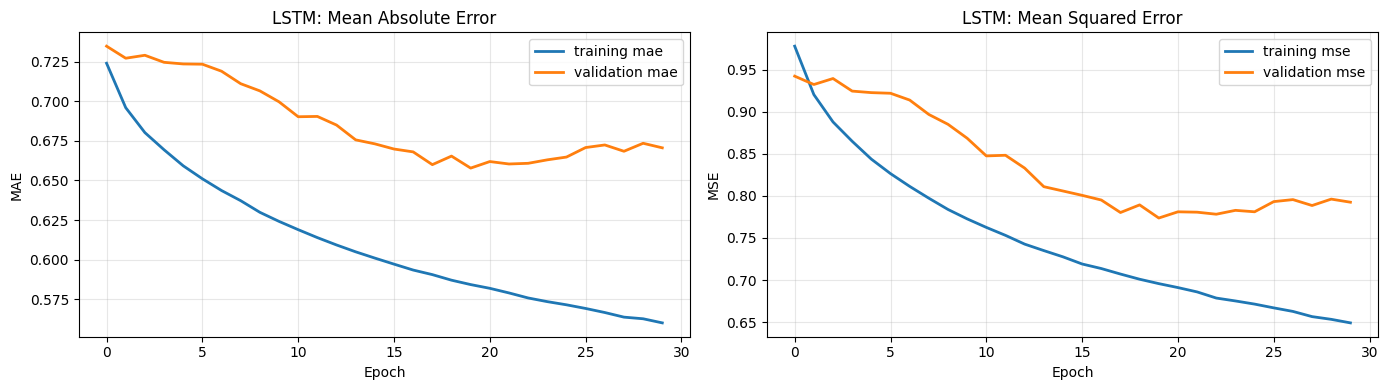

In [ ]:
# Visualize training history - LSTM
fig, axes = plt.subplots(1, 2, figsize=(14,4))

# MAE
axes[0].plot(history.history['mae'], label='training mae', linewidth=2)
axes[0].plot(history.history['val_mae'], label='validation mae', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MAE')
axes[0].set_title('LSTM: Mean Absolute Error')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MSE
axes[1].plot(history.history['mse'], label='training mse', linewidth=2)
axes[1].plot(history.history['val_mse'], label='validation mse', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MSE')
axes[1].set_title('LSTM: Mean Squared Error')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate model on test set
y_pred_scaled = model_lstm.predict(X_test_seq)

# Metrics on scaled data
mae = mean_absolute_error(y_test_seq, y_pred_scaled)
mse = mean_squared_error(y_test_seq, y_pred_scaled)

print("Test Set Performance (Scaled Data):")
print(f"   MAE:  {mae:.4f}")
print(f"   MSE:  {mse:.4f}")

1145/1145 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Test Set Performance (Scaled Data):
   MAE:  0.8103
   MSE:  1.0954


In [ ]:
# INVERSE TRANSFORM - Convert predictions back to original scale

# Inverse transform predictions
y_pred_original = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# Get actual original values using the tracked indices
# test_indices tells us which rows from df_test each prediction corresponds to
y_test_original = df_test.loc[test_indices, 'future_5_close_higher_than_today'].values

# Calculate metrics on ORIGINAL scale
mae = mean_absolute_error(y_test_original, y_pred_original)
mse = mean_squared_error(y_test_original, y_pred_original)

print("Test Set Performance (Original Scale):")
print(f"   MAE:  {mae:.4f}")
print(f"   MSE:  {mse:.4f}")
print(f"\nNote: {len(y_pred_original)} predictions aligned with original data using indices")

Test Set Performance (Original Scale):
   MAE:  9.2040
   MSE:  141.3178

Note: 36638 predictions aligned with original data using indices


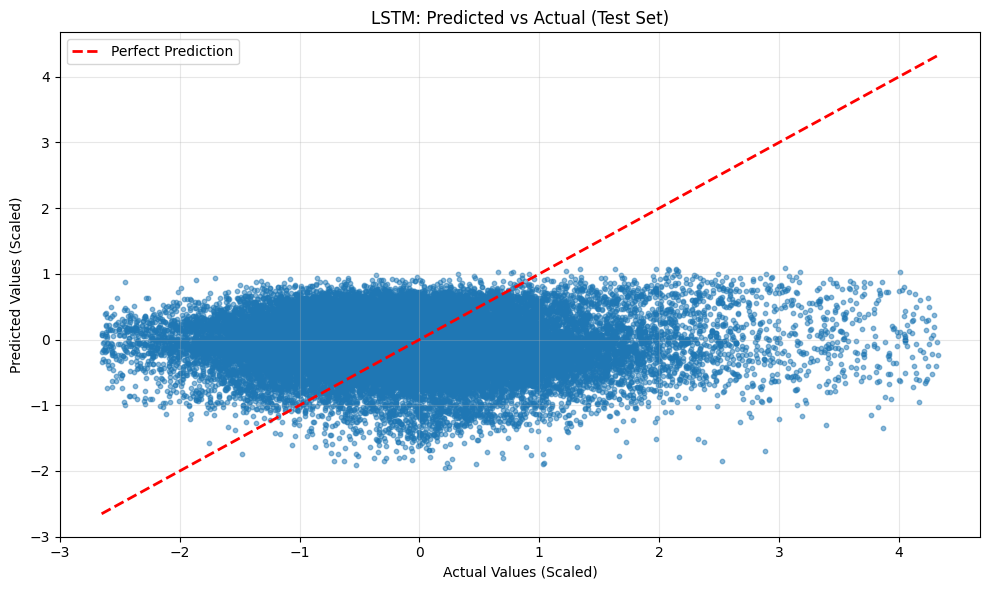

In [ ]:
# Visualize: Predicted vs Actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test_seq, y_pred_scaled, alpha=0.5, s=10)
plt.plot([y_test_seq.min(), y_test_seq.max()], 
         [y_test_seq.min(), y_test_seq.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Values (Scaled)')
plt.ylabel('Predicted Values (Scaled)')
plt.title('LSTM: Predicted vs Actual (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

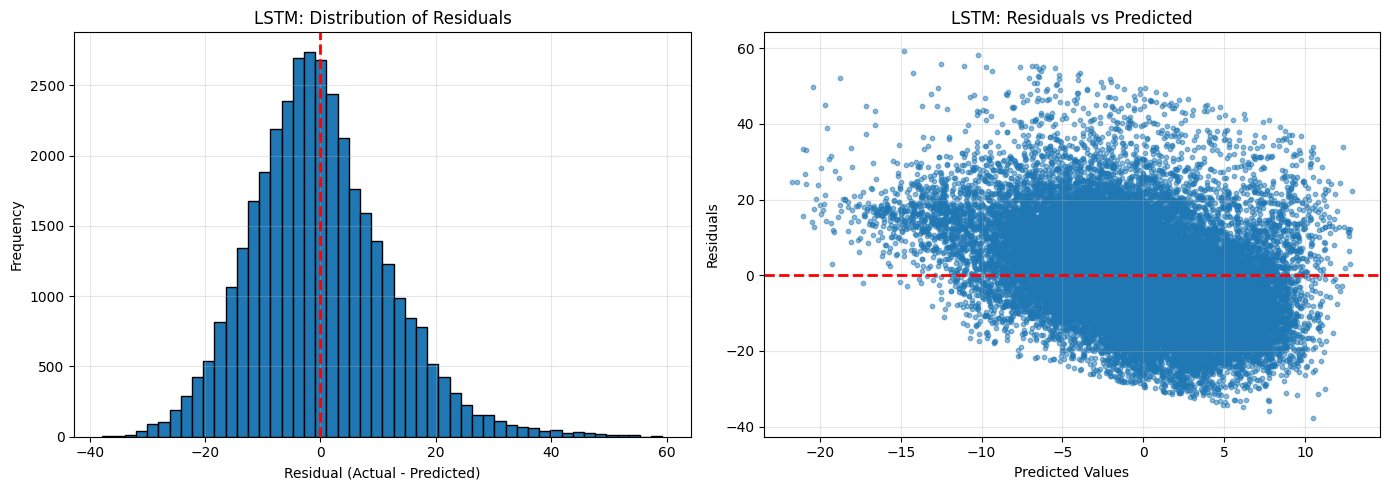

Residual Stats:
   Mean: -0.1141
   Std:  11.8872
   Min:  -37.7911
   Max:  59.2910


In [ ]:
# Visualize: Residuals Analysis - LSTM
residuals = y_test_original - y_pred_original

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residuals histogram
axes[0].hist(residuals, bins=50, edgecolor='black')
axes[0].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Residual (Actual - Predicted)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('LSTM: Distribution of Residuals')
axes[0].grid(True, alpha=0.3)

# Residuals vs Predicted
axes[1].scatter(y_pred_original, residuals, alpha=0.5, s=10)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Residuals')
axes[1].set_title('LSTM: Residuals vs Predicted')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Residual Stats:")
print(f"   Mean: {residuals.mean():.4f}")
print(f"   Std:  {residuals.std():.4f}")
print(f"   Min:  {residuals.min():.4f}")
print(f"   Max:  {residuals.max():.4f}")

In [ ]:
model_lstm.save('/Users/ina/Documents/spicedAcademy/time_series_project//models/model_lstm.keras')

In [ ]:
# MLflow Tracking
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

with mlflow.start_run(run_name=f"lstm_{timestamp}"):
    mlflow.log_param("lstm_units", lstm_units)
    mlflow.log_param("lstm_dropout", lstm_dropout)
    mlflow.log_param("use_second_lstm", use_second_lstm)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("L2_regularization", L2_regularization)
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("look_back", look_back)
    
    mlflow.log_metric("train_mae", mae_train)
    mlflow.log_metric("train_mse", mse_train)
    mlflow.log_metric("val_mae", val_mae)
    mlflow.log_metric("val_mse", val_mse)
    mlflow.log_metric("test_mae_scaled", mean_absolute_error(y_test_seq, y_pred_scaled))
    mlflow.log_metric("test_mse_scaled", mean_squared_error(y_test_seq, y_pred_scaled))
    mlflow.log_metric("test_mae_original", mean_absolute_error(y_test_original, y_pred_original))
    mlflow.log_metric("test_mse_original", mean_squared_error(y_test_original, y_pred_original))
    
    print(f"\nMLflow run logged with name: lstm_{timestamp}")